In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
results_df = pd.read_csv('runs.csv')
results_df = results_df[results_df.model_type != "XGBRFClassifier"]
rename_models = {
    "LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')": 'LogisticRegressionElasticnet',
    "LogisticRegression(penalty='l1', solver='liblinear')": 'LogisticRegressionLasso',
    "LogisticRegression()": "LogisticRegressionRidge",
    "LogisticRegression(penalty='none')": "LogisticRegression",
    "XGBClassifier(b": "XGBoost",
    "XGBRFClassifier": "XGBoost",
    "DummyClassifier(strategy='stratified')": "DummyClassifierStratified",
    "DummyClassifier(strategy='uniform')": "DummyClassifierUniform",
    "DummyClassifier()": "DummyClassifierMostFrequent",
    "LinearSVC()":"LinearSVC",
    "SVC()": "SVC",
    "RandomForestClassifier()": "RandomForestClassifier",
    "RidgeClassifier()": "RidgeClassifier"
}


results_df.model_type = results_df.model_type.map(rename_models)
results_df = results_df[['model_type', 'unit_of_analysis', 'n_features', 'f1_micro_mean', 'f1_micro_std']]\
    .sort_values(['model_type', 'unit_of_analysis'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'DummyClassifierMostFrequent'),
  Text(1, 0, 'DummyClassifierStratified'),
  Text(2, 0, 'DummyClassifierUniform'),
  Text(3, 0, 'LinearSVC'),
  Text(4, 0, 'LogisticRegression'),
  Text(5, 0, 'LogisticRegressionElasticnet'),
  Text(6, 0, 'LogisticRegressionLasso'),
  Text(7, 0, 'LogisticRegressionRidge'),
  Text(8, 0, 'RandomForestClassifier'),
  Text(9, 0, 'RidgeClassifier'),
  Text(10, 0, 'SVC'),
  Text(11, 0, 'XGBoost')])

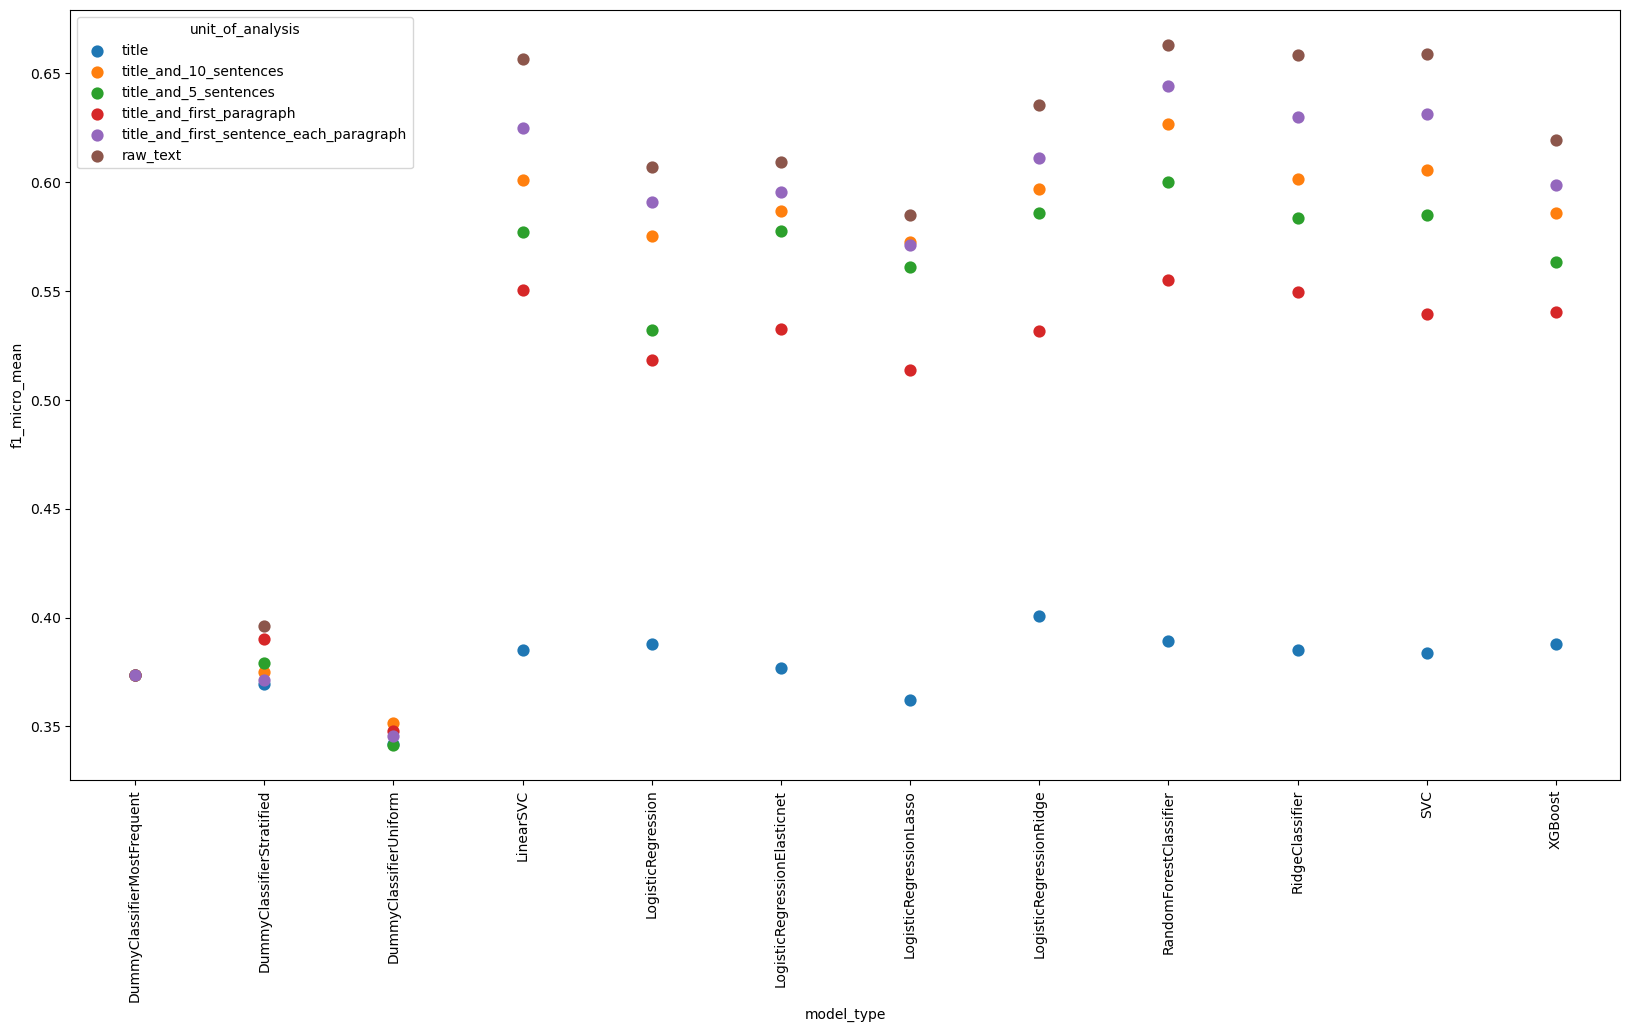

In [135]:
fig = plt.figure(figsize=(20,10))
ax = sns.pointplot(
    data=results_df.reset_index(),
    x='model_type',
    y='f1_micro_mean',
    hue='unit_of_analysis',
    join=False
)

plt.xticks(rotation=90)



In [144]:
results_df['model_type'].unique()

array(['DummyClassifierMostFrequent', 'DummyClassifierStratified',
       'DummyClassifierUniform', 'LinearSVC', 'LogisticRegression',
       'LogisticRegressionElasticnet', 'LogisticRegressionLasso',
       'LogisticRegressionRidge', 'RandomForestClassifier',
       'RidgeClassifier', 'SVC', 'XGBoost'], dtype=object)

In [145]:
results_df['model_type'] = pd.Categorical(results_df['model_type'], categories= results_df['model_type'].unique(), ordered=True)

(0.0, 1.0)

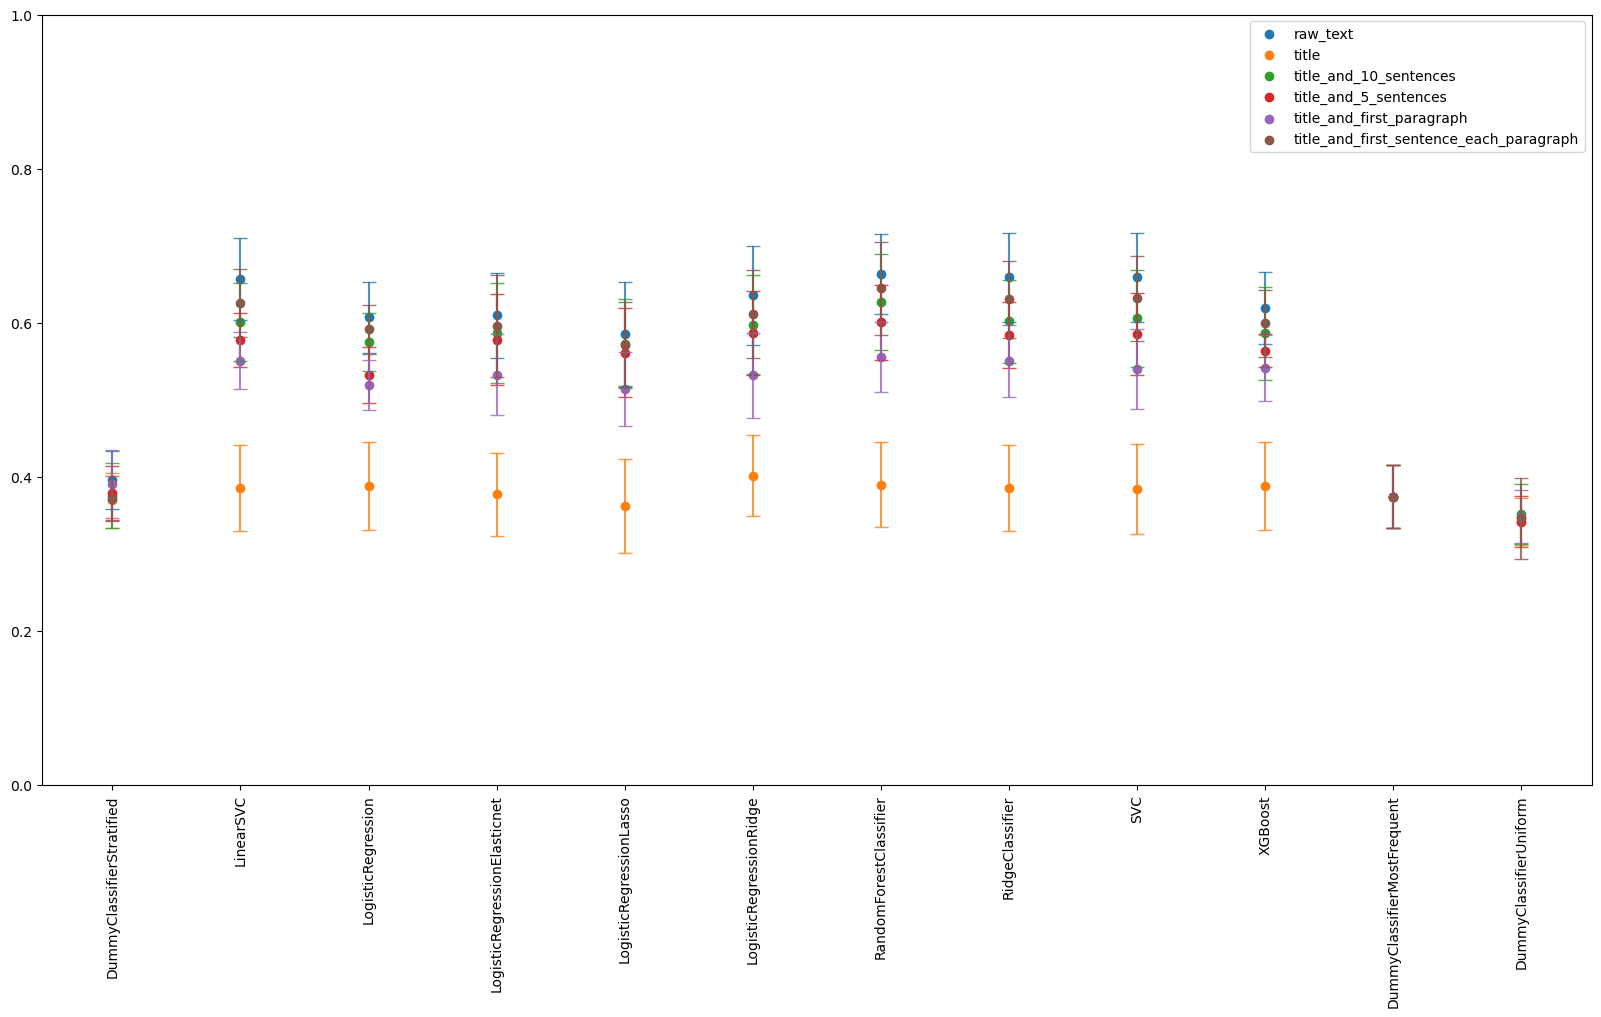

In [157]:
fig = plt.figure(figsize=(20,10))
for unit_of_analysis, df in results_df.groupby('unit_of_analysis'):
    df['model_type'] = pd.Categorical(df['model_type'], categories= df['model_type'].unique(), ordered=True)
    df=df.sort_values(['model_type']).reset_index()
    plt.errorbar(df.model_type, df.f1_micro_mean, yerr=df.f1_micro_std, linestyle='',  capsize=5, alpha=0.8)
    plt.scatter(df.model_type, df.f1_micro_mean, label=unit_of_analysis)

plt.xticks(rotation=90)
plt.legend()
plt.ylim(0,1)

The raw text outperforms in all of the models. However, when we take into account the variations, almost all units of analysis perform the same except for just the title.

The best models - though all are within the standard deviation of the others - seem to be RandomForest, LinearSVC, and RidgecClassifier

# Load the information of the experiments with default performance and no form of balancing or 

# Check confusion matrices of the best performing models

After training without any form of balancing or weighing, the best performing modes were RandomForest, LinearSVC, SVC, and the RidgeClassifier.

Let's look at them closely, particularly at their confusion matrice